In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
tickers = list(prices.columns[:-4])+['현금']

In [4]:
oecd = pd.read_csv("data/OECD.csv", index_col=0, parse_dates=True).rename_axis("Date")
oecd_MOM = oecd.resample('D').first().fillna(method='ffill') #전월비
target_weights1 = pd.DataFrame(np.where(oecd_MOM > 1, 1, 0), index=oecd_MOM.index)
target_weights1['현금'] = 1 - target_weights1
target_weights1.columns = ['base1', '현금'] # 'base1'은 위의 전략과 이름을 맞추어야 한다. '현금'도 prices의 컬럼이름과 맞추어야 한다.


kbase1 = bt.Strategy('kbase1',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=1, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights1, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [5]:
dd = pd.read_csv('월별투자자별매매동향대신.csv', index_col=0, parse_dates=True)
외국인수급 = dd.loc['2001':'2021-08', '외국인'].copy().to_frame()
외국인수급.columns = ['kospi']
외국인수급 = 외국인수급.resample('MS').first().shift(1)
외국인수급 = 외국인수급 - 외국인수급.min()
외국인수급['1m'] = 외국인수급['kospi'].pct_change(1)
외국인수급['2m'] = 외국인수급['kospi'].pct_change(1).shift(1)
외국인수급['3m'] = 외국인수급['kospi'].pct_change(1).shift(2)
연속3개월 = ((외국인수급['3m'] > 0) & (외국인수급['2m'] > 0) & (외국인수급['1m'] > 0))
연속2개월 = ((외국인수급['2m'] > 0) & (외국인수급['1m'] > 0))
연속1개월 = (외국인수급['1m'] > 0)
target_weights2 = pd.DataFrame(np.where(연속3개월, 1.0,
                                        np.where(연속2개월, 0.66,
                                                np.where(연속1개월, 0.33, 0))),
                             index=외국인수급.index, columns=['base2'])
target_weights2['현금'] = 1.0 - target_weights2
target_weights2.columns = ['base2', '현금']

kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights2, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [6]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]

c='코스피200'
target_weights3 = pd.DataFrame()
target_weights3['base3'] = prices[c].rolling(365).apply(AMS)
target_weights3['현금'] = 1.0 - target_weights3
target_weights3.columns = ['base3', '현금']

kbase3 = bt.Strategy(
    'kbase3',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=3, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights3, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [7]:
kbase123 = bt.Strategy(
    'kbase123',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
#         bt.algos.PrintDate(),
        bt.algos.SelectAll(),
    #   bt.algos.SelectThese(tickers),
    # 변동성 제어한 비중에 대한 dataframe
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children = [kbase1, kbase2, kbase3]
)

In [45]:
start_date = datetime(1950, 1, 1)
unrate = web.DataReader("UNRATE","fred",start_date)#,end_date)
unrate['12ma'] = unrate.rolling(12).mean()
unrate_shifted = unrate.shift(1)
us500 = yf.download('^GSPC')[['Adj Close']]
us500.columns = ['US500']
us500['200ma'] = us500['US500'].rolling(200).mean()
signal = bt.merge(us500, unrate_shifted)
signal = signal.fillna(method='ffill')
signal = signal['1993':].copy()
cond1 = (signal['US500'] < signal['200ma'])
cond2 = (signal['UNRATE'] > signal['12ma'])
signal['berish'] = (cond1 & cond2)
signal = signal.resample('D').fillna('ffill')
#%%
read_df = pd.read_csv('./data/laa_assets.csv', index_col=0, parse_dates=True)
cols = ['us500_UH', 'gold_H', 'usbond10y_UH', 'nasdaq100_UH', 'usdkrw'] # SHY대용 국내 ETF는?
price_df = read_df.loc[:, cols].dropna().copy()
price_df = price_df['2001':'2020-07-02'].copy()
#%%
class WeighLAA(bt.Algo):
    def __init__(self, signal_name):
        super(WeighLAA, self).__init__()
        self.signal_name = signal_name

    def is_berish_and_depression(self, signal):
        return signal == True

    def current_weights(self, target):
        weights = pd.Series()
        for cname in target.children:
            c = target.children[cname]
            weights[cname] = c.weight
        return weights

    def __call__(self, target):
        t0 = target.now
        weights = self.current_weights(target) # 한국형으로 가지고 있다.
        # print(t0, weights.index, weights.values)
        signal = target.get_data(self.signal_name)
        if self.is_berish_and_depression(signal.loc[t0].values[0]): # SHY
            if 'nasdaq100_UH' in weights.index:
                if weights['nasdaq100_UH'] != 0.0: # QQQ에 투자중이라면
                    weights['usdkrw'] = weights['nasdaq100_UH']

                weights.drop(labels=['nasdaq100_UH'], inplace=True)
        else: # QQQ
            if 'usdkrw' in weights.index:
                if weights['usdkrw'] != 0: # SHY에 투자 중이라면
                    weights['nasdaq100_UH'] = weights['usdkrw']

                weights.drop(labels=['usdkrw'], inplace=True)

        # 1년 한번 전체 비중을 맞춘다.
        if t0.month == 12:
            for name in weights.index:
                weights[name] = 0.25

        target.temp['weights'] = weights
        # print(f'{t0} {weights}')
        return True
# %%
#%%
class SelectAsset(bt.Algo):
    def __init__(self, signal_name):
        super(SelectAsset, self).__init__()
        self.signal_name = signal_name

    def is_berish_and_depression(self, signal):
        return signal == True

    def __call__(self, target):
        t0 = target.now
        signal = target.get_data(self.signal_name)

        if self.is_berish_and_depression(signal.loc[t0].values[0]):
            target.temp["selected"] = ['us500_UH', 'gold_H', 'usbond10y_UH', 'usdkrw']
        else:
            target.temp["selected"] = ['us500_UH', 'gold_H', 'usbond10y_UH', 'nasdaq100_UH']

        return True

# %%
START_DATE='1993-01-29'#'2004-11-18'
once = bt.AlgoStack(#bt.algos.RunAfterDate('2004-11-29'),
                    bt.algos.RunAfterDate('2002-1-2'),
                    bt.algos.RunOnce(),
                    bt.algos.PrintDate(),
                    # bt.algos.SelectThese(['IWD', 'GLD', 'IEF', 'QQQ']), # FIXME: 2004-11-29일 하락장아님 QQQ선택 (signal을 보고 미리 선택했음)
                    SelectAsset('Growth_Trend'),
                    bt.algos.WeighEqually(),
                    bt.algos.PrintTempData(),
                    bt.algos.Rebalance())
laa = bt.AlgoStack(
    bt.algos.RunAfterDate('2002-1-2'),
    bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True),
    bt.algos.PrintDate(),
    bt.algos.SelectAll(),
    WeighLAA('Growth_Trend'),
    # bt.algos.PrintTempData(),
    bt.algos.Rebalance()
)

st = bt.Strategy("LAA",
    [
        bt.algos.Or([once, laa])
    ])        


[*********************100%***********************]  1 of 1 completed


In [46]:
통합 = bt.Strategy(
    '통합',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        # bt.algos.PrintDate(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()],
)

In [47]:
bt_kbase1 = bt.Backtest(kbase1, prices)
bt_kbase2 = bt.Backtest(kbase2, prices)
bt_kbase3 = bt.Backtest(kbase3, prices)

bt_kbase123 = bt.Backtest(kbase123, prices)
bt_laa = bt.Backtest(st, price_df, additional_data={'Growth_Trend':signal[['berish']]})

r1 = bt.run(bt_laa)
r2 = bt.run(bt_kbase123)

# r = bt.run(bt_kbase1, bt_kbase2, bt_kbase3)
# rr = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123)

2002-01-03 00:00:00
{'selected': ['us500_UH', 'gold_H', 'usbond10y_UH', 'usdkrw'], 'weights': {'us500_UH': 0.25, 'gold_H': 0.25, 'usbond10y_UH': 0.25, 'usdkrw': 0.25}}
2002-01-31 00:00:00
2002-02-28 00:00:00
2002-03-29 00:00:00
2002-04-30 00:00:00
2002-05-31 00:00:00
2002-06-28 00:00:00
2002-07-31 00:00:00
2002-08-30 00:00:00
2002-09-30 00:00:00
2002-10-31 00:00:00
2002-11-29 00:00:00
2002-12-30 00:00:00
2003-01-30 00:00:00
2003-02-28 00:00:00
2003-03-31 00:00:00
2003-04-30 00:00:00
2003-05-30 00:00:00
2003-06-30 00:00:00
2003-07-31 00:00:00
2003-08-29 00:00:00
2003-09-30 00:00:00
2003-10-31 00:00:00
2003-11-28 00:00:00
2003-12-30 00:00:00
2004-01-30 00:00:00
2004-02-27 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-05-31 00:00:00
2004-06-30 00:00:00
2004-07-30 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-10-29 00:00:00
2004-11-30 00:00:00
2004-12-30 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-04-29 00:00:00
2005-05-31 00:00:00
2005-06-30 0

합성지수를 만든다.

In [48]:
data = bt.merge(r1['LAA'].prices, r2['kbase123'].prices)
data.head()

,LAA,kbase123
2001-01-01,100.000,100.000
2001-01-02,100.000,100.000
2001-01-03,100.000,100.000
2001-01-04,100.000,100.000
2001-01-05,100.000,100.000


In [50]:
bt_통합 = bt.Backtest(통합, data)
r3 = bt.run(bt_통합)

In [51]:
r3.set_date_range("2002-02-01")
r3.display()

Stat                 통합
-------------------  ----------
Start                2002-02-01
End                  2020-07-02
Risk-free rate       0.00%

Total Return         872.83%
Daily Sharpe         1.38
Daily Sortino        2.30
CAGR                 13.15%
Max Drawdown         -17.70%
Calmar Ratio         0.74

MTD                  1.43%
3m                   15.20%
6m                   13.09%
YTD                  12.93%
1Y                   17.10%
3Y (ann.)            8.72%
5Y (ann.)            10.39%
10Y (ann.)           11.07%
Since Incep. (ann.)  13.15%

Daily Sharpe         1.38
Daily Sortino        2.30
Daily Mean (ann.)    13.04%
Daily Vol (ann.)     9.45%
Daily Skew           -0.03
Daily Kurt           5.63
Best Day             4.28%
Worst Day            -3.98%

Monthly Sharpe       1.39
Monthly Sortino      3.34
Monthly Mean (ann.)  12.55%
Monthly Vol (ann.)   9.06%
Monthly Skew         0.60
Monthly Kurt         1.77
Best Month           11.96%
Worst Month          -6.31%

Year

In [52]:
r_all = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123, bt_laa, bt_통합)
r_all.set_date_range("2002-02-01")
r_all.display()

Stat                 kbase1      kbase2      kbase3      kbase123    LAA         통합
-------------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2002-02-01  2002-02-01  2002-02-01  2002-02-01  2002-02-01  2002-02-01
End                  2020-07-02  2020-07-02  2020-07-02  2020-07-02  2020-07-02  2020-07-02
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         5821.11%    437.70%     858.74%     1477.59%    432.29%     872.83%
Daily Sharpe         1.05        0.70        0.80        1.04        0.97        1.38
Daily Sortino        1.69        1.10        1.27        1.70        1.57        2.30
CAGR                 24.81%      9.56%       13.06%      16.16%      9.50%       13.15%
Max Drawdown         -29.47%     -25.76%     -40.90%     -28.83%     -14.08%     -17.70%
Calmar Ratio         0.84        0.37        0.32        0.56        0.67        0.74

MTD                  4.87% 

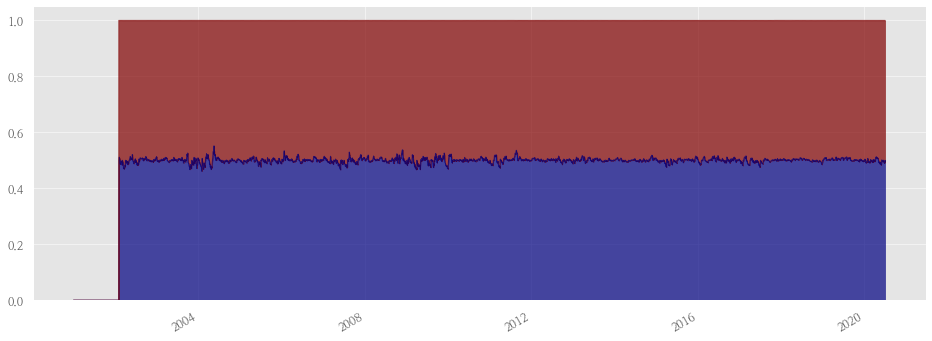

In [53]:
r_all.get_security_weights('통합').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

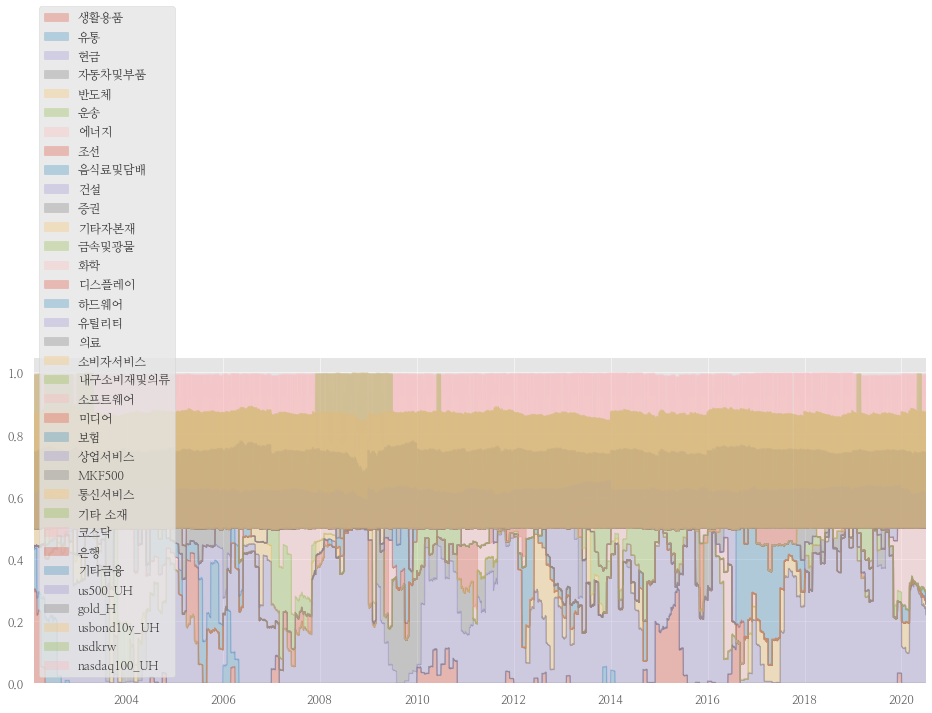

In [57]:
dollar_assets_weights = r1.get_security_weights()*0.5
kbase123_weights = r2.get_security_weights()*0.5
security_weights = bt.merge(kbase123_weights, dollar_assets_weights)
security_weights = security_weights['2002-02-01':]
security_weights.plot.area(stacked=True, alpha=0.3, legend=True, figsize=(16,6));

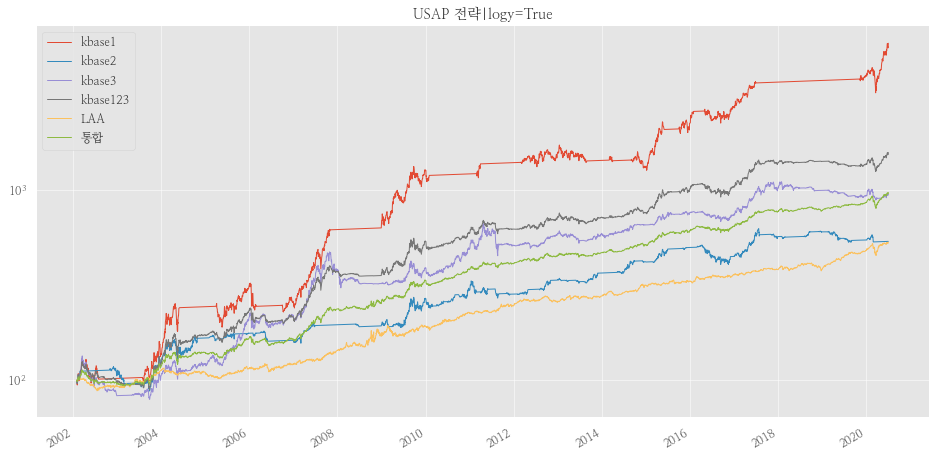

In [58]:
ax = r_all.plot(figsize=(16,8), logy=True, title="USAP 전략|logy=True");
plt.legend(loc="upper left");

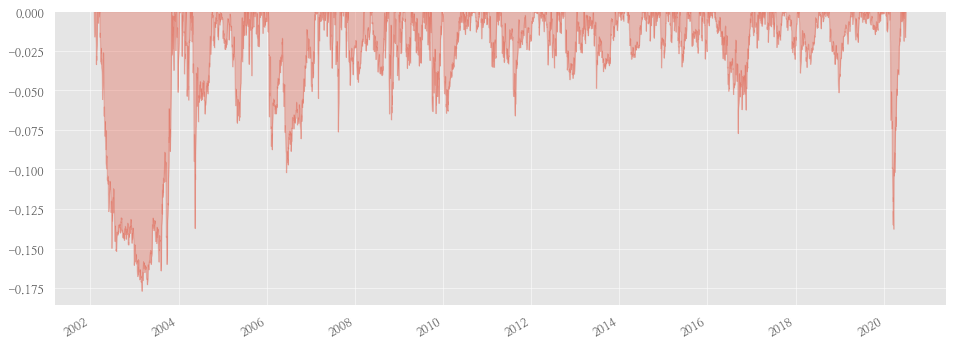

In [59]:
r_all['통합'].prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

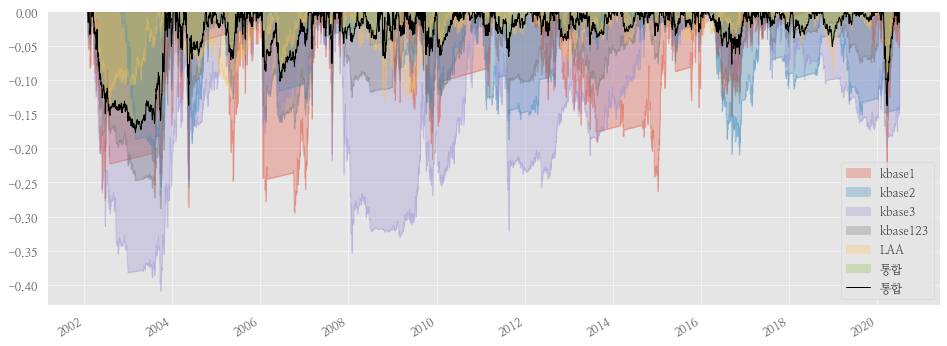

In [62]:
ax1 = r_all.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));
r3.prices.to_drawdown_series().plot(color='black', ax=ax1);

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-04  2002-02-04
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          872.83%     1,477.59%
CAGR﹪                     13.15%      16.16%

Sharpe                     1.38        1.04
Smart Sharpe               1.31        0.98
Sortino                    2.06        1.55
Smart Sortino              1.95        1.46
Sortino/√2                 1.45        1.09
Smart Sortino/√2           1.38        1.04
Omega                      1.29        1.29

Max Drawdown               -17.7%      -28.83%
Longest DD Days            594         905
Volatility (ann.)          9.45%       15.93%
R^2                        0.72        0.72
Calmar                     0.74        0.56
Skew                       -0.03       0.13
Kurtosis                   5.63      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2002-03-20,2003-03-03,2003-11-04,594,-17.698,-17.213
2,2020-02-21,2020-03-23,2020-05-22,91,-13.771,-13.513
3,2004-04-23,2004-05-17,2004-10-07,167,-13.732,-12.036
4,2006-01-10,2006-06-13,2007-02-06,392,-10.198,-9.680
5,2016-03-03,2016-09-12,2017-01-03,306,-7.723,-6.211


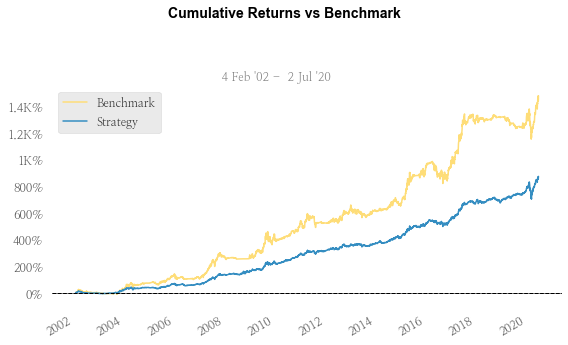

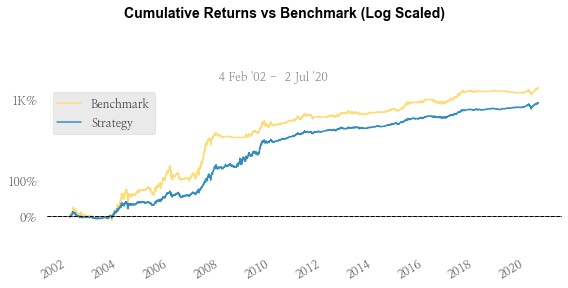

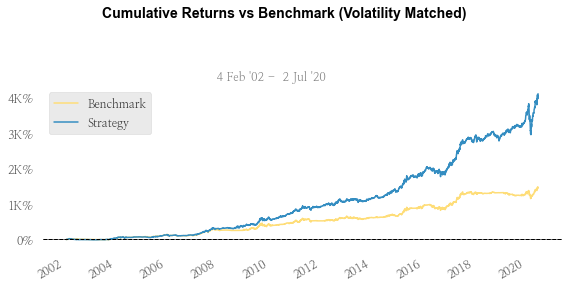

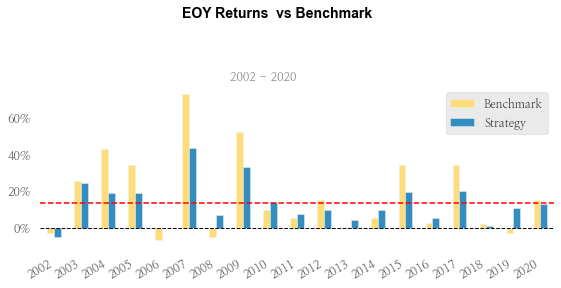

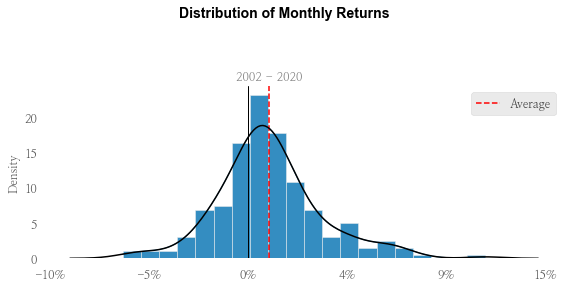

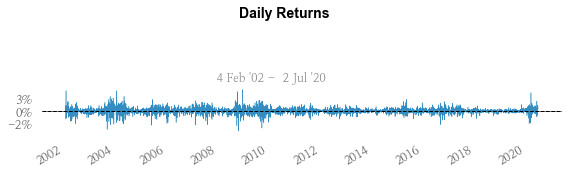

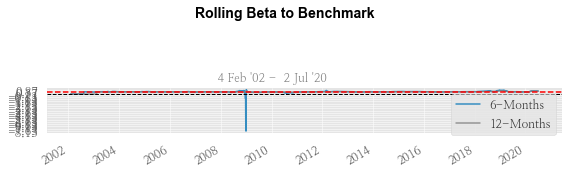

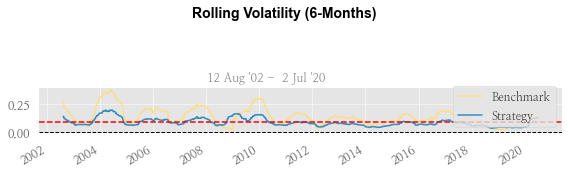

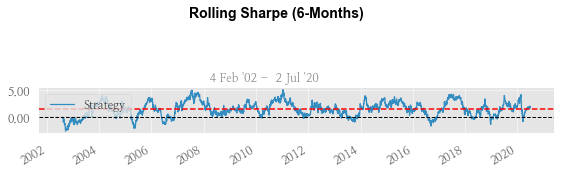

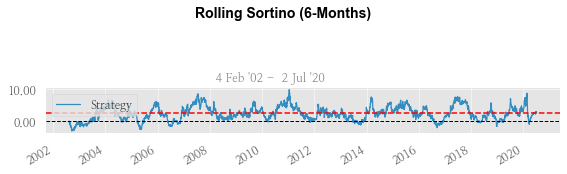

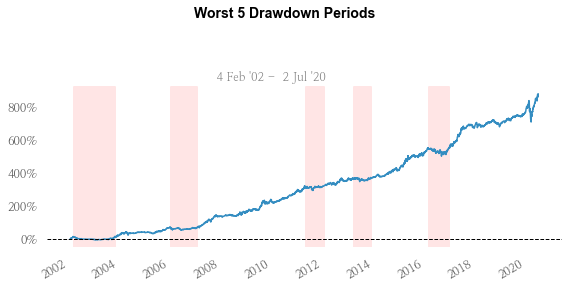

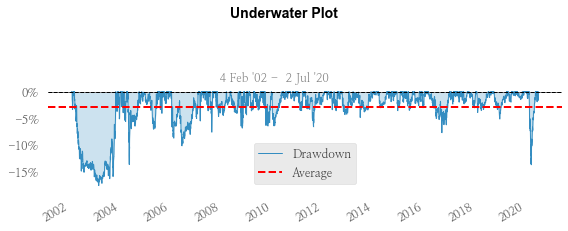

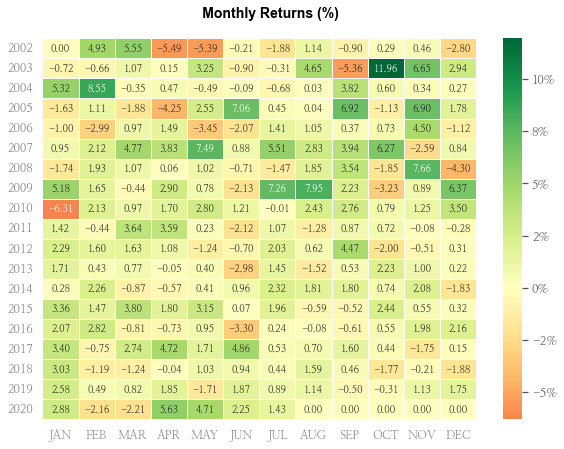

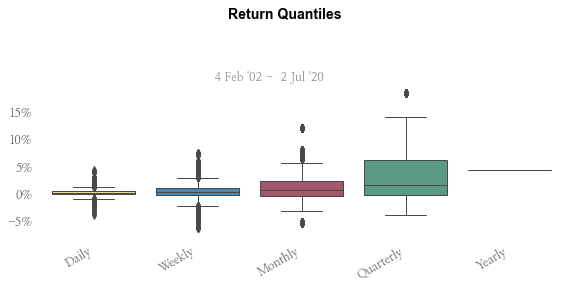

In [63]:
qs.reports.full(r_all['통합'].prices.to_returns().dropna(), 
                r_all['kbase123'].prices.to_returns().dropna())

2020-07-02 00:00:00


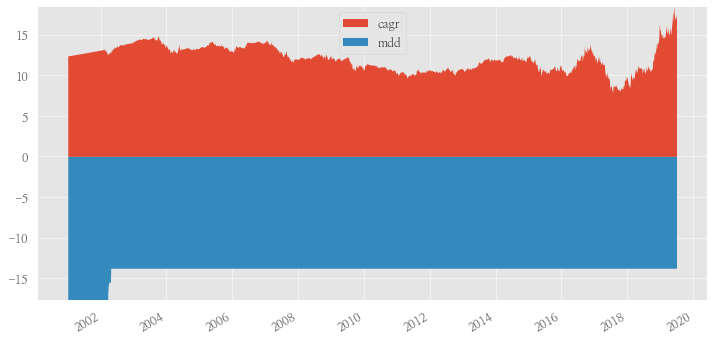

In [64]:
투자시점별CAGRMDD(bt_통합)


2020-07-02 00:00:00


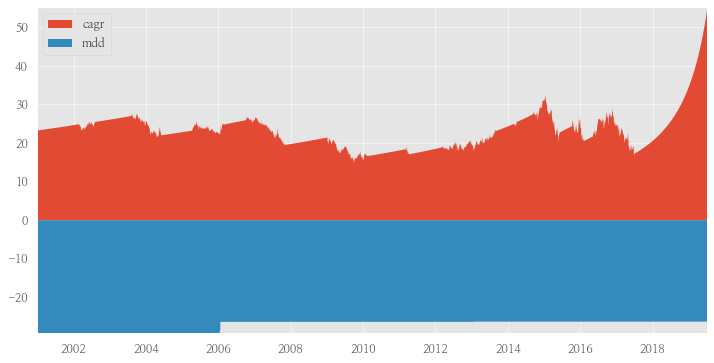

In [65]:
투자시점별CAGRMDD(bt_kbase1)

2020-07-02 00:00:00


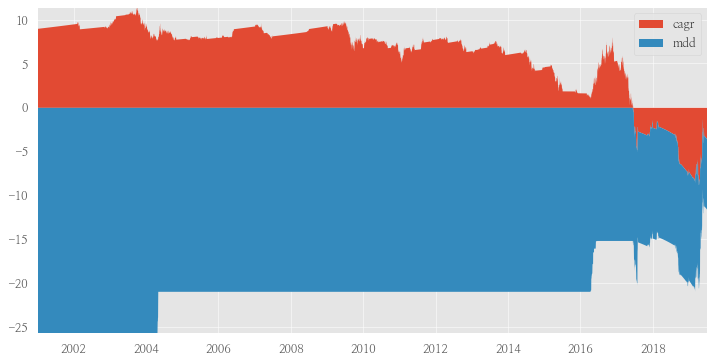

In [66]:
투자시점별CAGRMDD(bt_kbase2)

2020-07-02 00:00:00


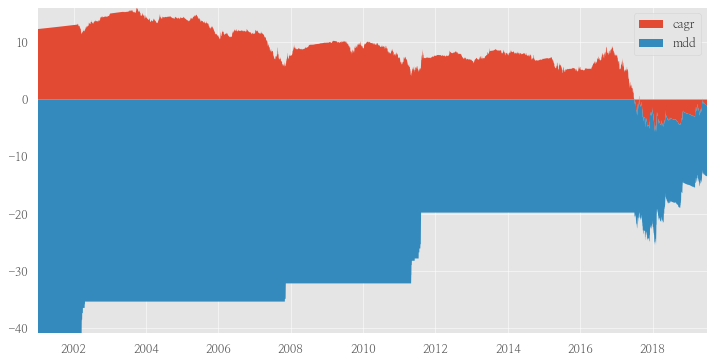

In [68]:
투자시점별CAGRMDD(bt_kbase3)

2020-07-02 00:00:00


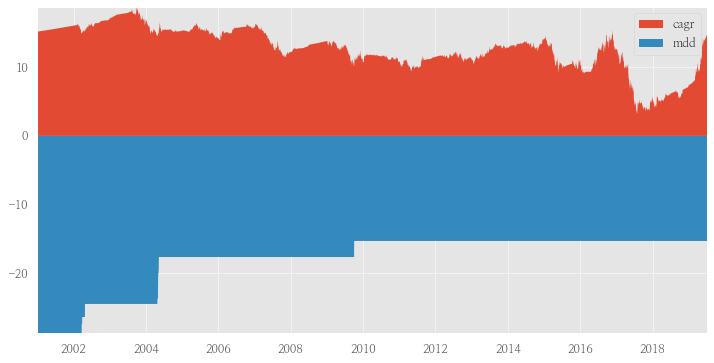

In [67]:
투자시점별CAGRMDD(bt_kbase123)

2020-07-02 00:00:00


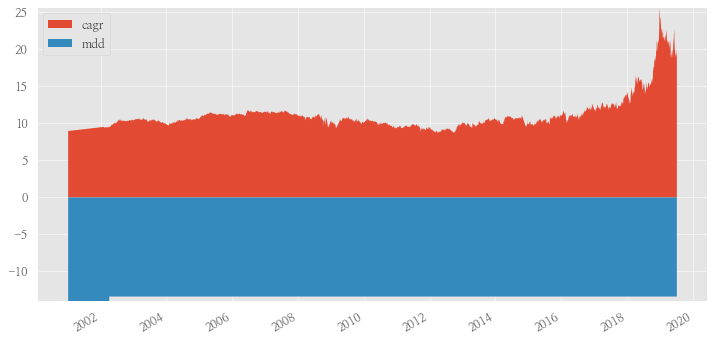

In [69]:
투자시점별CAGRMDD(bt_laa)

In [71]:
r_all.backtests['통합'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
4,2002-03-20 00:00:00,2003-11-04 00:00:00,594,-0.177
245,2020-02-21 00:00:00,2020-05-22 00:00:00,91,-0.138
14,2004-04-23 00:00:00,2004-10-07 00:00:00,167,-0.137
34,2006-01-10 00:00:00,2007-02-06 00:00:00,392,-0.102
188,2016-03-03 00:00:00,2017-01-03 00:00:00,306,-0.077
53,2007-07-26 00:00:00,2007-08-31 00:00:00,36,-0.076
16,2004-11-15 00:00:00,2005-06-30 00:00:00,227,-0.071
68,2008-10-09 00:00:00,2008-11-21 00:00:00,43,-0.069
115,2011-04-26 00:00:00,2012-01-30 00:00:00,279,-0.066
85,2009-09-24 00:00:00,2009-12-23 00:00:00,90,-0.065


In [72]:
r_all.backtests['통합'].stats.drawdown_details.sort_values(by="Length", ascending=False).head(20)

,Start,End,Length,drawdown
4,2002-03-20 00:00:00,2003-11-04 00:00:00,594,-0.177
34,2006-01-10 00:00:00,2007-02-06 00:00:00,392,-0.102
188,2016-03-03 00:00:00,2017-01-03 00:00:00,306,-0.077
115,2011-04-26 00:00:00,2012-01-30 00:00:00,279,-0.066
136,2013-03-15 00:00:00,2013-11-28 00:00:00,258,-0.049
16,2004-11-15 00:00:00,2005-06-30 00:00:00,227,-0.071
222,2018-10-05 00:00:00,2019-04-03 00:00:00,180,-0.051
14,2004-04-23 00:00:00,2004-10-07 00:00:00,167,-0.137
213,2018-01-30 00:00:00,2018-07-12 00:00:00,163,-0.039
86,2009-12-28 00:00:00,2010-05-25 00:00:00,148,-0.064
